In [591]:
from torch.utils import data as D
import torch
import torch.nn as nn
import torch.nn.functional as F

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, rdMolDescriptors, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Scaffolds import MurckoScaffold
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
from scipy.stats import permutation_test
warnings.simplefilter('ignore')

from rdkit.ML.Scoring import Scoring
from scipy.stats import gamma
from matplotlib.legend_handler import HandlerLine2D
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (matthews_corrcoef, 
                             confusion_matrix, 
                             f1_score, 
                             roc_auc_score,
                             accuracy_score,
                             auc, precision_recall_curve, roc_curve)

## Import the training, validation and test datasets

In [12]:
import pickle

with open('only_unique_examples_data/train_labels_and_smiles.pcl', 'rb') as f:
    [train_labels, train_smiles] = pickle.load( f)
    
with open('only_unique_examples_data/val_labels_and_smiles.pcl', 'rb') as f:
    [val_labels, val_smiles] = pickle.load(f)
    
with open('only_unique_examples_data/test_labels_and_smiles.pcl', 'rb') as f:
    [test_labels, test_smiles] = pickle.load( f)
    
with open('idx_to_target_name.pcl', 'rb') as f:
    idx_to_target_name = pickle.load(f)

In [13]:
class ChEMBLDataset(D.Dataset):
    
    def __init__(self, smiles_list, labels, radius_fp=2, length_of_fp=2048, mask_id=0):
        """
        The dataset is constructed such that the mask provides a convenient way to access features and label for each target.
        """
        self.mask_id = mask_id
        self.smiles_list = smiles_list
        self.n_tasks = len(self.smiles_list)
        self.labels = labels
        self.all_mols_list = self.preprocess_molecules()
        self.bv_fps = []
        self.fps = []
        self.bv_pos_fps = []
        
        for i in range(self.n_tasks):
            tmp = [self.calc_fp(mol, 2048, 2) for mol in self.all_mols_list[i]]
            tmp2 = [self.calc_fp_bv(mol, 2048, 2) for mol in self.all_mols_list[i]]
            mask = np.where(val_labels[i] == 1., True, False)
            mask = sum(mask)
            self.fps.append(tmp)
            self.bv_fps.append(tmp2)
            self.bv_pos_fps.append(tmp2[:mask])
        self.fps = np.array(self.fps)
        
    def preprocess_molecules(self):
        """
        Preprocessing of molecules - standardises, neutralises and canonicalises molecules.
        """
        all_mols_list = []
        all_failed = []
        for j in range(self.n_tasks):
            failed = []
            mols_list = []
            for i,smiles in tqdm(enumerate(self.smiles_list[j])):
                try:
                    mol = Chem.MolFromSmiles(smiles)
                    # standardize molecule
                    clean_mol = rdMolStandardize.Cleanup(mol) 
                    # Returns the largest fragment after doing a cleanup
                    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

                    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
                    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
                    te = rdMolStandardize.TautomerEnumerator() 
                    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
                    mols_list.append(taut_uncharged_parent_clean_mol)
                except Exception as e:
                    print(repr(e))
                    failed.append(i)
            all_mols_list.append(mols_list)
            all_failed.append(failed)
        
        for j in range(self.n_tasks):
            self.smiles_list[j] = np.delete(self.smiles_list[j],all_failed[j])
            self.labels[j] = np.delete(self.labels[j],all_failed[j])
     
        return all_mols_list
    
    def calc_fp(self, mol, fp_size, radius):
        """
        calcs morgan fingerprint as NumPy array.
        """
        mol.UpdatePropertyCache(False)
        Chem.GetSSSR(mol)
        fp = rdMolDescriptors.GetMACCSKeysFingerprint(mol)
        a = np.zeros((0,), dtype=np.float32)
        Chem.DataStructs.ConvertToNumpyArray(fp, a)
        return a
    
    def calc_fp_bv(self, mol, fp_size, radius):
        """
        calcs morgan fingerprints as a BV
        """
        mol.UpdatePropertyCache(False)
        Chem.GetSSSR(mol)
        fp = rdMolDescriptors.GetMACCSKeysFingerprint(mol)
        return fp
    
    def __len__(self):
        return len(self.fps[self.mask_id])
    
    def change_mask(self, mask_id):
        self.mask_id = mask_id
    
    def __getitem__(self, index):
        return self.fps[self.mask_id][index], self.labels[self.mask_id][index]

In [588]:
class ChEMBLDataset_ecfp4(D.Dataset):
    """
    The point of this second dataset is to load the test data results from the ECFP4 model
    for determining statistical significance of the metrics with a permutation test later.
    Otherwise it is the same.
    """
    
    def __init__(self, smiles_list, labels, radius_fp=2, length_of_fp=2048, mask_id=0):
        """
        Assumes the smiles list provided is valid.
        """
        self.mask_id = mask_id
        self.smiles_list = smiles_list
        self.n_tasks = len(self.smiles_list)
        self.labels = labels
        self.all_mols_list = self.preprocess_molecules()
        self.bv_fps = []
        self.fps = []
        self.bv_pos_fps = []
        
        for i in range(self.n_tasks):
            tmp = [self.calc_fp(mol, 2048, 2) for mol in self.all_mols_list[i]]
            tmp2 = [self.calc_fp_bv(mol, 2048, 2) for mol in self.all_mols_list[i]]
            mask = np.where(self.labels[i] == 1., True, False)
            mask = sum(mask)
            self.fps.append(tmp)
            self.bv_fps.append(tmp2)
            self.bv_pos_fps.append(tmp2[:mask])
        self.fps = np.array(self.fps)

        
    def preprocess_molecules(self):
        all_mols_list = []
        all_failed = []
        for j in range(self.n_tasks):
            failed = []
            mols_list = []
            for i,smiles in tqdm(enumerate(self.smiles_list[j])):
                try:
                    mol = Chem.MolFromSmiles(smiles)

                    clean_mol = rdMolStandardize.Cleanup(mol) 

                    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

                    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
                    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
                    te = rdMolStandardize.TautomerEnumerator() 
                    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
                    mols_list.append(taut_uncharged_parent_clean_mol)
                except Exception as e:
                    print(repr(e))
                    failed.append(i)
            all_mols_list.append(mols_list)
            all_failed.append(failed)
        
        for j in range(self.n_tasks):
            self.smiles_list[j] = np.delete(self.smiles_list[j],all_failed[j])
            self.labels[j] = np.delete(self.labels[j],all_failed[j])
     
        return all_mols_list
    
    def calc_fp(self, mol, fp_size, radius):
        """
        calcs morgan fingerprints as a numpy array.
        """
        mol.UpdatePropertyCache(False)
        Chem.GetSSSR(mol)
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius, nBits=fp_size, useChirality=True)
        a = np.zeros((0,), dtype=np.float32)
        Chem.DataStructs.ConvertToNumpyArray(fp, a)
        return a
    
    def calc_fp_bv(self, mol, fp_size, radius):
        """
        calcs morgan fingerprints as a BV
        """
        mol.UpdatePropertyCache(False)
        Chem.GetSSSR(mol)
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius, nBits=fp_size, useChirality=True)
        return fp
    
    def __len__(self):
        return len(self.fps[self.mask_id])
    
    def change_mask(self, mask_id):
        self.mask_id = mask_id
    
    def __getitem__(self, index):
        return self.fps[self.mask_id][index], self.labels[self.mask_id][index]

### The captures I am using to not print out messages that come from the standardisation of molecules by RDKit

In [14]:
%%capture train
train_dataset = ChEMBLDataset(train_smiles, train_labels, )

In [15]:
%%capture val
val_dataset = ChEMBLDataset(val_smiles, val_labels, );

In [592]:
%%capture test
test_dataset = ChEMBLDataset(test_smiles, test_labels,)
test_dataset_ecfp4 = ChEMBLDataset_ecfp4(test_smiles, test_labels,)

In [17]:
## Global parameters of the model
BATCH_SIZE = 32  # based on https://arxiv.org/abs/1804.07612
LR = 0.0002
MODEL_PATH = 'only_unique_examples_data/model_maccs_0002.pcl'

In [594]:
# Set seed for reproducibility
g = torch.Generator()
g.manual_seed(42)
train_loader = D.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)

val_loader = D.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)

test_loader = D.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)


## Weights for the loss are 1/number of examples. Targets with more examples are given lower weight as there are plenty of examples to learn from that contribute to the loss. Positive weighting to help with the class imbalance (puts more weight on the underrepresented positive class).

In [593]:
weights = []
pos_weights = []
for head in range(train_dataset.n_tasks):
    train_dataset.change_mask(head)
    weights.append(1 / len(train_dataset))
    print(len(train_dataset))
    num_pos = sum(train_dataset.labels[head])
    num_neg = len(train_dataset) - num_pos
    pos_weights.append(num_neg / num_pos)
weights = torch.tensor(weights)
tot = sum(weights)
for i in range(len(weights)):
    weights[i] /= tot

1145
1964
703
6871
6183
553
3643
289
1760


In [589]:
class ChEMBLMultiTask(nn.Module):
    """
    Architecture borrowed from: https://www.nature.com/articles/s41598-022-23203-y#ref-CR13
    """
    def __init__(self, n_tasks, input_features):
        super(ChEMBLMultiTask, self).__init__()
        self.n_tasks = n_tasks
        self.fc1 = nn.Linear(input_features, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.dropout = nn.Dropout(0.5)

        # add an independet output for each task int the output laer
        for n_m in range(self.n_tasks):
            self.add_module(f"y{n_m}o", nn.Linear(128, 1))
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        out = [getattr(self, f"y{n_m}o")(x) for n_m in range(self.n_tasks)]
        return out
    
# create the model
model = ChEMBLMultiTask(val_dataset.n_tasks, 167)
model_ecfp4 = ChEMBLMultiTask(val_dataset.n_tasks, 2048) # will be used to later load the best ECFP4 model

# the negative frequency for a class is the positive weighting for the loss
# use loss with logits because it is more numerically stable
criterion = [nn.BCEWithLogitsLoss(weight=w, pos_weight=torch.tensor(pw, dtype=torch.float32)) for x, w, pw in zip(range(val_dataset.n_tasks), weights, pos_weights)]

optimizer = torch.optim.Adam(model.parameters(), LR)

In [26]:
def train(model, loader, optimizer, criterions):
    model.train()
    tot_loss = 0
    loss_by_target = {}
    for head in range(loader.dataset.n_tasks):
        loader.dataset.change_mask(head)
        optimizer.zero_grad()
        loss_by_target[head] = 0
        
        #curr_loss = 0
        loss = torch.tensor(0.)
        for i, (X, y) in enumerate(loader):
            y_hat = model(X)
            loss_head = criterions[head](y_hat[head], torch.tensor(y, dtype=torch.float).view(-1, 1))
            loss += loss_head
            loss_by_target[head] += loss_head.item()
            
        loss.backward()
        optimizer.step()
        tot_loss += loss.item()
    return tot_loss, loss_by_target

In [600]:
def test(model, loader, criterions):
    """
    Executes a testing epoch and keeps track of varius metrics.
    """
    model.eval()
    predictions = {i:np.array([]) for i in range(loader.dataset.n_tasks)} # predicted labels for each tarrget
    pred_probas = {i:[] for i in range(loader.dataset.n_tasks)} # predicted probabilities
    trues = {i:[] for i in range(loader.dataset.n_tasks)} # true labels
    sorteds = {i:[] for i in range(loader.dataset.n_tasks)} # sorted labels (to be used with ranking metrics)

    f1s, mccs, auprcs, aurocs = [], [],[],[] # F1 scores, MCCs, AUPRCs, AUROCs
    bedrocs = [] # BEDROCs, 
    sigm = nn.Sigmoid()
    loss_by_target = {}
    
    tot_loss = 0
    with torch.no_grad():
        for head in range(loader.dataset.n_tasks):
            loss_by_target[head] = 0
            loader.dataset.change_mask(head)
            loss = torch.tensor(0.)
            for i, (X, y) in enumerate(loader):
                y_hat = model(X)
                loss_head = criterions[head](y_hat[head], torch.tensor(y, dtype=torch.float).view(-1, 1))
                loss += loss_head
                loss_by_target[head] += loss_head.item()
                pred_probas[head].extend(sigm(y_hat[head].detach().cpu().view(-1)))
                trues[head].extend(torch.tensor(y, dtype=torch.float))
            
            predictions[head] = torch.where(torch.tensor(pred_probas[head]) > 0.5, torch.ones(1), torch.zeros(1)).view(-1)
            tn, fp, fn, tp = confusion_matrix(trues[head], predictions[head]).ravel()
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
            prec = tp / (tp + fp)
            f1 = f1_score(trues[head], predictions[head])
            acc = accuracy_score(trues[head], predictions[head])
            mcc = matthews_corrcoef(trues[head], predictions[head])
            precision, recall, thresholds = precision_recall_curve(trues[head], pred_probas[head])
            auprc = auc(recall, precision)
            auroc = roc_auc_score(trues[head], pred_probas[head]) #auc(1 - spec, sens)
            f1s.append(f1)
            mccs.append(mcc)
            auprcs.append(auprc)
            aurocs.append(auroc)
            tot_loss += loss.item()
            
            _dict = {i:n for i, n in enumerate(pred_probas[head])}
            _to_sort = [[n,i, true_or_false] for i, n,true_or_false in zip(range(len(pred_probas[head])),pred_probas[head], trues[head])]
            _sorted = sorted(_to_sort , key=lambda x: x[0], reverse=True)
            bedroc = Scoring.CalcBEDROC(_sorted, 2, 20)
            
            
            bedrocs.append(bedroc)
            sorteds[head] = _sorted
            
            
    return tot_loss, loss_by_target, sorteds, f1s, mccs, auprcs, aurocs, bedrocs, predictions, pred_probas, trues

In [28]:
## Set the seed for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [40]:
# initialise arrays to store metrics from training - some of them I have not used yet, but I try to log as much information as might need
train_losses = []
val_losses = []
test_losses = []
best_val_loss = torch.inf
best_epoch = -1
f1s,mccs, auprcs, aurocs, bedrocs = [],[],[],[],[]

t_f1s,t_mccs, t_auprcs, t_aurocs, t_bedrocs = [],[],[],[],[]
val_sorteds_li, test_sorteds_li = [],[]
train_loss_by_target_li, val_loss_by_target_li , test_loss_by_target_li= [], [], []

for e in range(50):
    train_loss, train_loss_by_target = train(model, train_loader, optimizer, criterion)
    val_loss,val_loss_by_target, val_sorteds, f1,mcc, auprc, auroc, bedroc, predictions, pred_probas, trues  = test(model, val_loader, criterion)
    
    f1s.append(f1)
    mccs.append(mcc)
    auprcs.append(auprc)
    aurocs.append(auroc)
    bedrocs.append(bedroc)
    
    test_loss, test_loss_by_target, test_sorteds, f1,mcc, auprc, auroc, bedroc, test_predictions, test_pred_probas, test_trues  = test(model, test_loader, criterion)
    t_f1s.append(f1)
    t_mccs.append(mcc)
    t_auprcs.append(auprc)
    t_aurocs.append(auroc)
    t_bedrocs.append(bedroc)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    train_loss_by_target_li.append(train_loss_by_target)
    val_loss_by_target_li.append(val_loss_by_target)
    test_loss_by_target_li.append(test_loss_by_target)
    
    val_sorteds_li.append(val_sorteds)
    test_sorteds_li.append(test_sorteds)
    
    print(train_loss,val_loss,)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = e
        
        torch.save(model.state_dict(), MODEL_PATH)
    
    if best_epoch + 10 < e:
        print(f'STOPPING EARLY in epoch: {e+1}')
        break

39.45591378211975 8.566033124923706
39.26326942443848 8.58169835805893
42.358612060546875 8.60864382982254
38.45290684700012 8.39292722940445
38.12153220176697 8.446054756641388
37.71640157699585 8.196508169174194
36.95016646385193 8.0430389046669
36.67588663101196 8.068881034851074
35.719083070755005 7.903813064098358
35.27009201049805 7.665957927703857
34.50861096382141 7.729056298732758
34.01043939590454 7.482298344373703
33.3679473400116 7.405107796192169
32.58721423149109 7.2548534870147705
32.63427186012268 7.217118620872498
31.400556564331055 7.134649932384491
33.42309808731079 7.011668503284454
31.221457481384277 6.933670550584793
30.138566374778748 6.802639126777649
29.648746609687805 6.802320122718811
28.93038296699524 6.814362123608589
28.661813616752625 6.82463912665844
28.230441331863403 6.7810716181993484
28.704182147979736 6.68792861700058
27.777364253997803 6.589171186089516
27.86756730079651 6.513953506946564
27.161925792694092 6.524381101131439
27.15277397632599 6.537

# Plot losses

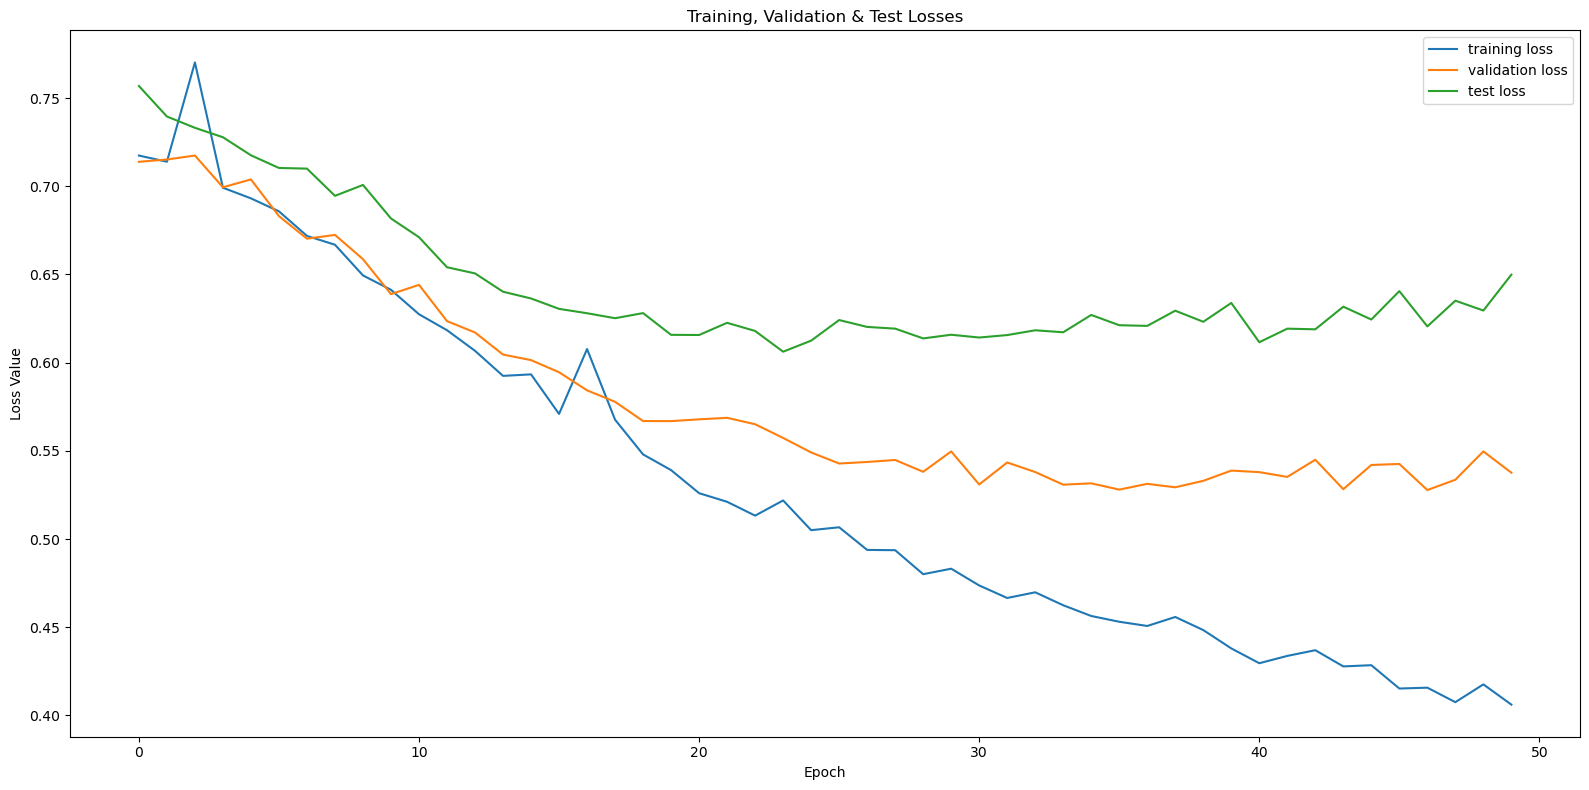

In [502]:
plt.figure(figsize=(16, 8))
sn.lineplot(x=range(len(train_losses)),y=np.array(train_losses) /len(train_loader), label='training loss') #16692)*1000)#len(train_loader))#16692)
sn.lineplot(x=range(len(val_losses)),y=np.array(val_losses) / len(val_loader), label='validation loss')#3603) * 1000)#len(val_loader))#3603)
sn.lineplot(x=range(len(test_losses)),y=np.array(test_losses) / len(test_loader), label='test loss')#3603) * 1000)#len(val_loader))#3603)
plt.legend()
plt.title('Training, Validation & Test Losses')
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.tight_layout()
plt.savefig('pictures_2/losses_maccs_0002_with_test_model.png')

### Here one could plot the various metrics that have been tracked during training to see if there is actual improvement over time

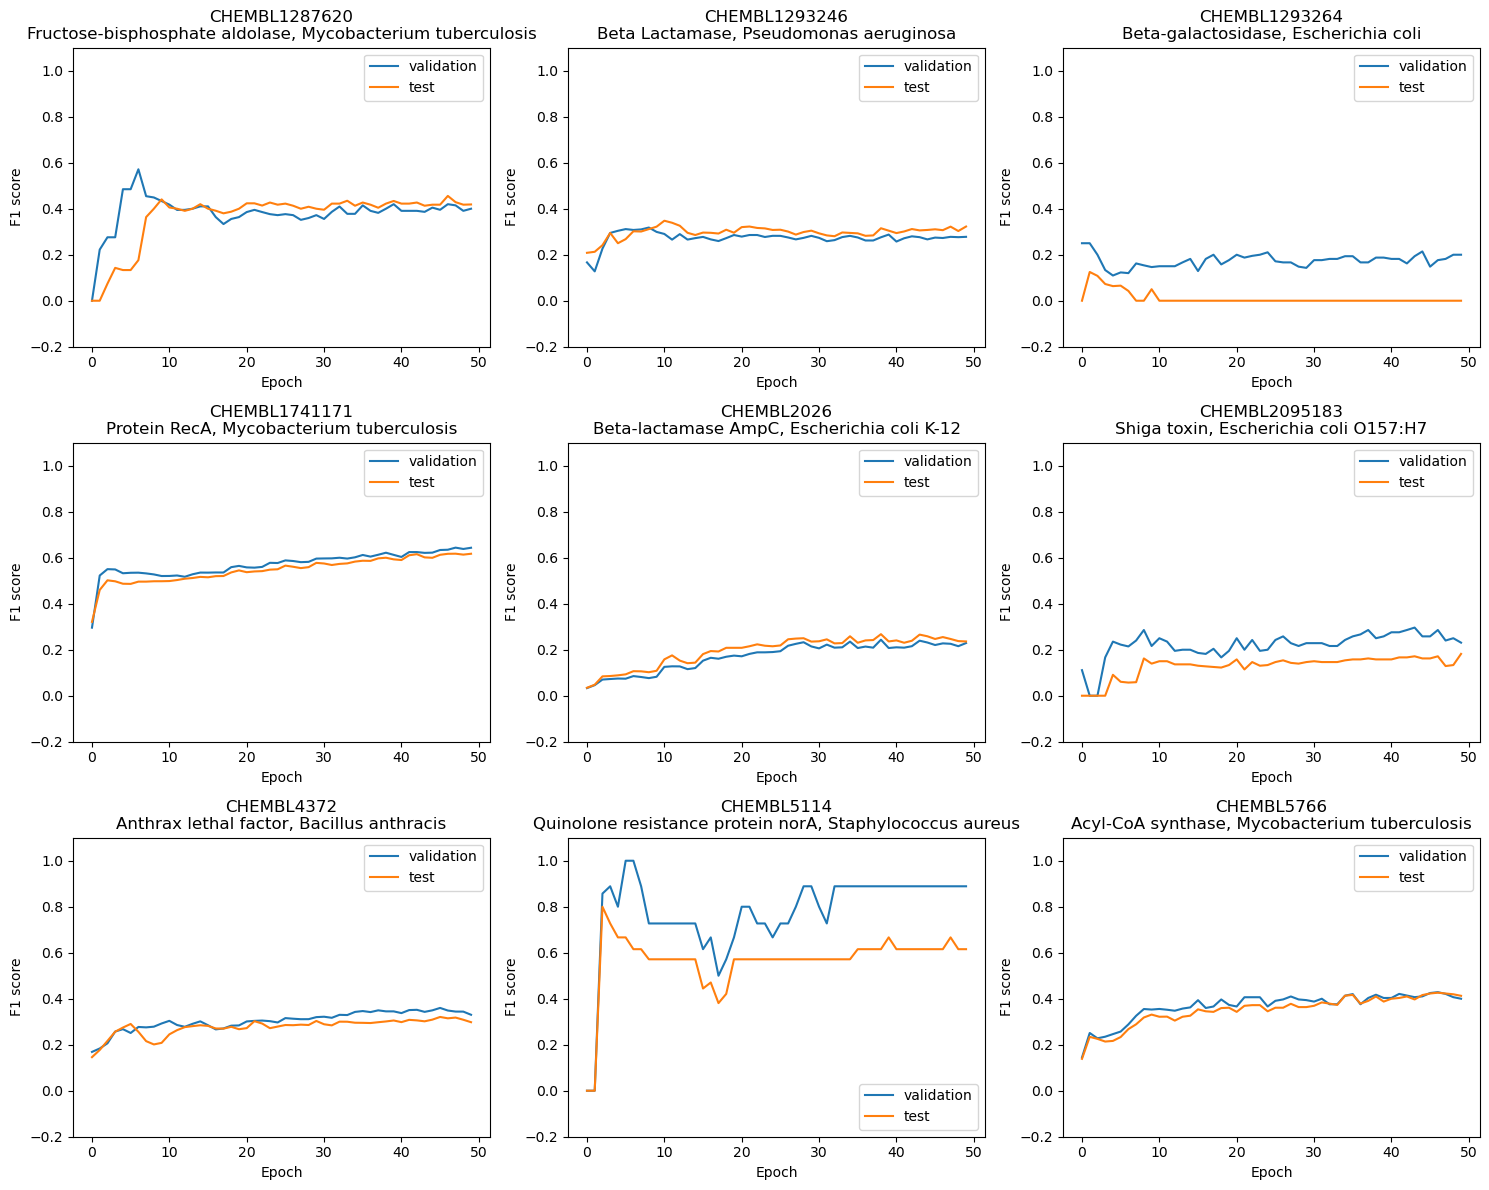

In [611]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for head,ax in zip(range(9), axs.ravel()): #f1,mcc, auprc, auroc, bedroc, random_bedroc,):
    sn.lineplot(x=range(len(np.array(f1s)[:,head])), y=np.array(f1s)[:,head], ax=ax, label='validation')
    sn.lineplot(x=range(len(np.array(t_f1s)[:,head])), y=np.array(t_f1s)[:,head], ax=ax, label='test')
    ax.set_title(idx_to_target_name[head])
    ax.legend()
    ax.set_ylim((-0.2,1.1))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('F1 score')
    plt.tight_layout()
#plt.savefig('pictures_2/f1scores.png')

### The loss of the best model

In [597]:
np.argmin(val_losses)

46

In [598]:
model.load_state_dict(torch.load(f"./{MODEL_PATH}"))

<All keys matched successfully>

In [601]:
test_loss, test_loss_by_target, test_sorteds, f1,mcc, auprc, auroc, bedroc, random_bedroc, test_predictions, test_pred_probas, test_trues  = test(model, test_loader, criterion)

### Functions for plotting the various metrics

In [618]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, ax):
    sn.lineplot(x=thresholds, y=precisions[:-1], label="Precision", linewidth=2, ax=ax)
    sn.lineplot(color="green",x=thresholds, y=recalls[:-1],label="Recall", linewidth=2, ax=ax)
    ax.legend(loc="best", fontsize=16) 
    ax.set_xlabel("Threshold", fontsize=16)        
    ax.grid(True)                              

def plot_precision_vs_recall(precisions, recalls,color,label, ax=None):
    sn.lineplot(x=recalls, y=precisions, linewidth=2, color=color,label=label, ax=ax)
    ax.set_xlabel("Recall", fontsize=16)
    ax.set_ylabel("Precision", fontsize=16)
    ax.axis([-0.1, 1.1, -0.1, 1.1])
    ax.grid(True)

    
def plot_roc_curve(fpr, tpr, label, ax=None):
    sn.lineplot(fpr, tpr, linewidth=2, label=label, ax=ax)
    ax.axis([-0.1, 1.1, 0, 1.1])                                  
    #plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    #plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    ax.grid(True)        

## Get the predictions for the baseline random and prior (predicts the class frequency) models

In [427]:
prior_classifier = DummyClassifier(strategy='prior')
random_classifier = DummyClassifier(strategy='uniform', random_state=42)

In [449]:
def get_random_predictions(X):
    length = X.shape[0]
    return np.array([random.uniform(0.,1.0) for _ in range(length)])

In [457]:
prior_proba_predictions, random_proba_predictions = [], []
prior_predictions, random_predictions = [], []
for head in range(9):
    prior_classifier = prior_classifier.fit(train_dataset.fps[head], train_dataset.labels[head])
    prior_proba_predictions.append(prior_classifier.predict_proba(test_dataset.fps[head]))
    prior_predictions.append(prior_classifier.predict(test_dataset.fps[head]))
    
    random_proba_predictions.append(get_random_predictions(test_dataset.labels[head]))
    random_classifier = random_classifier.fit(train_dataset.fps[head], train_dataset.labels[head])
    random_predictions.append(random_classifier.predict(test_dataset.fps[head]))

### Estimate the random classifier's probability distribution by bootstrapping

In [466]:
random_auprcs_all = []
random_aurocs_all = []
for head in range(9):
    _auprcs = []
    _aurocs = []
    for _ in tqdm(range(1000)):
        random_pred_probas = get_random_predictions(test_dataset.labels[head])
        test_precision_auc, test_recall_auc, test_threshold_auc = precision_recall_curve(test_trues[head], random_pred_probas)
        _auprcs.append(auc(test_recall_auc, test_precision_auc))
        _aurocs.append(roc_auc_score(test_trues[head], random_pred_probas))
    random_auprcs_all.append(_auprcs)
    random_aurocs_all.append(_aurocs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [612]:
auroc

[0.8819875776397517,
 0.8177884615384615,
 0.23003472222222224,
 0.895470771976796,
 0.9265470792211257,
 0.6016016016016016,
 0.7898073836276083,
 0.9694915254237289,
 0.8418262653898768]

##  Test for statistical significance of the trained classifier against the random 
### Require prediction to be better than the top 5th percentile

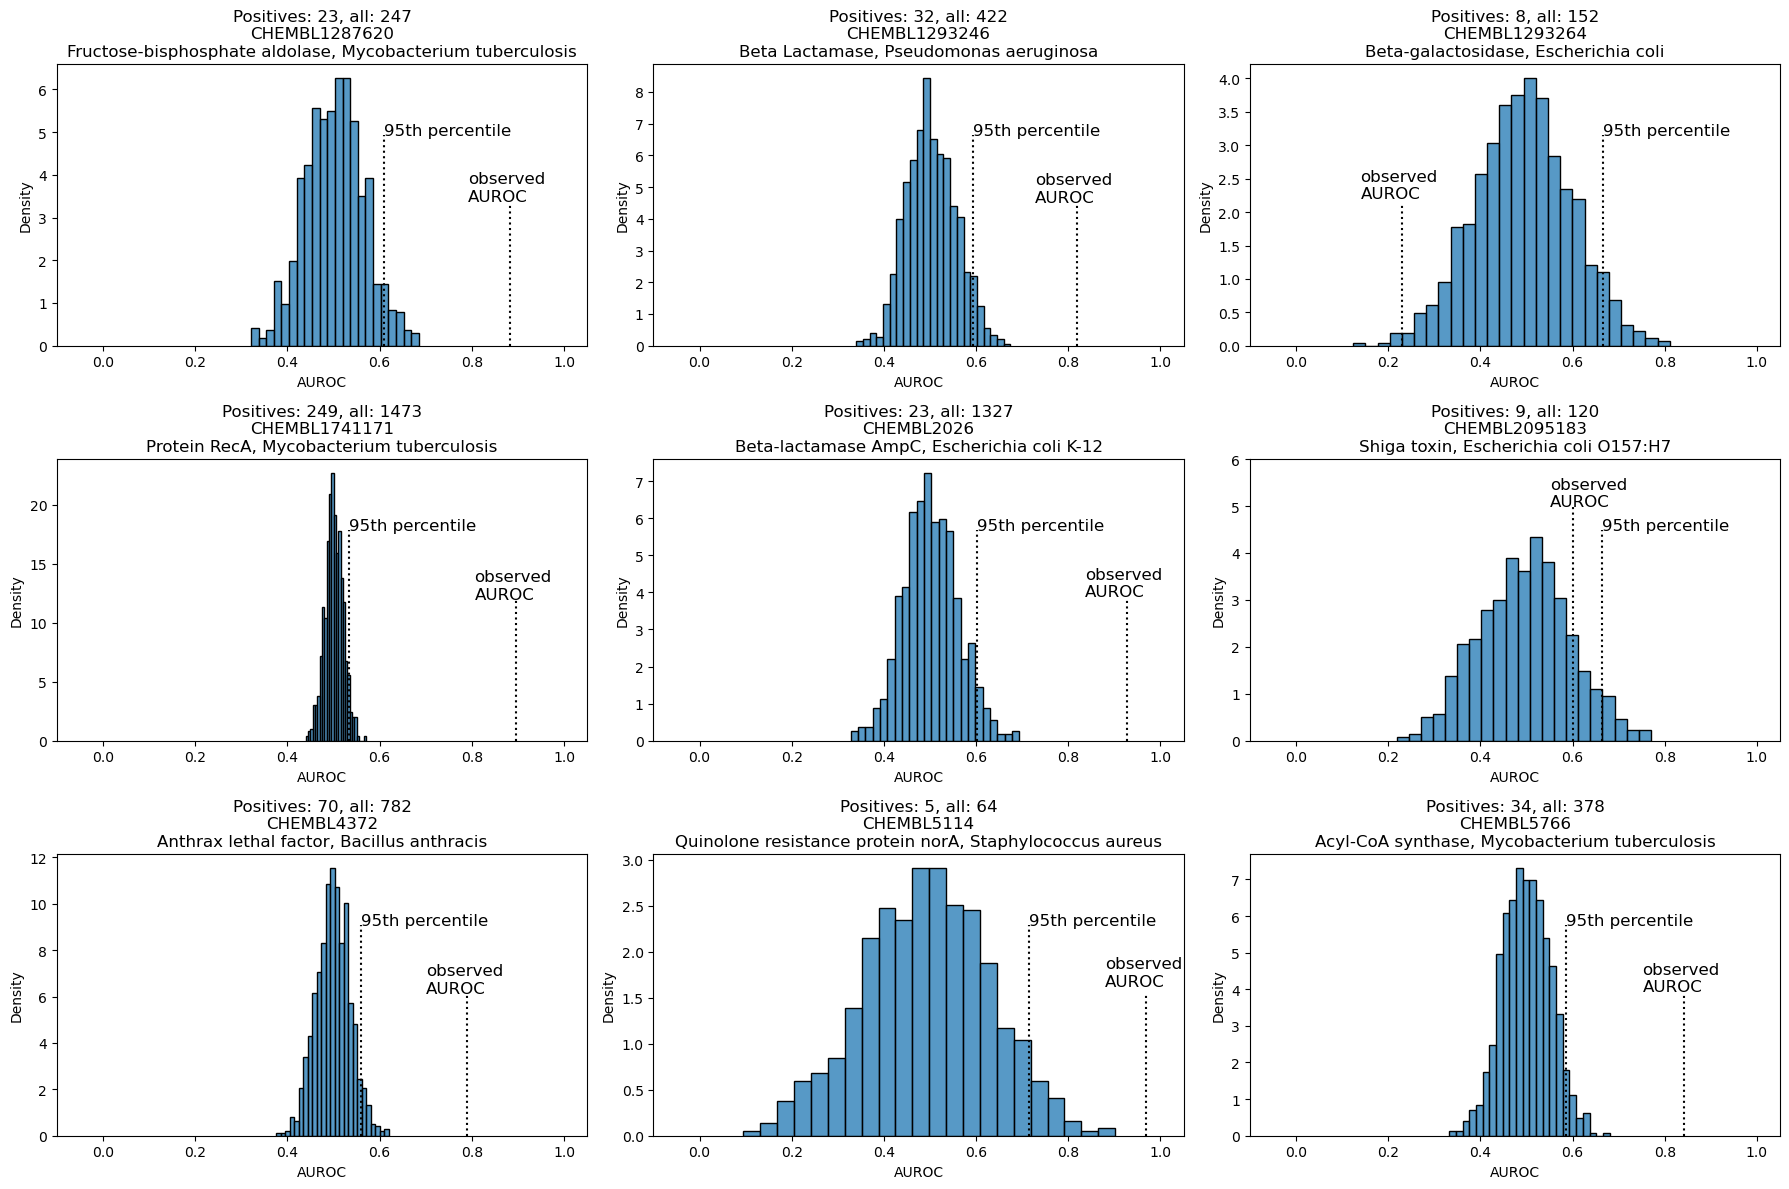

In [604]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18,12))
for i, ax in zip(range(9), axs.ravel(), ):
    sn.histplot(random_aurocs_all[i], stat='density', ax=ax)
    ax.set_xlim((-0.1,1.05))
    ax.set_title('Positives: '+ str(int(sum(test_labels[i]))) + ', all: ' + str(len(test_labels[i])) + '\n' + idx_to_target_name[i])  
    #test_fpr, test_tpr, test_thresholds = roc_curve(test_trues[head], test_pred_probas[head][:])
    ax.set_xlabel('AUROC')
    if i != 41 and i != 5:
        ax.vlines(np.quantile(random_aurocs_all[i], 0.95), ymin=0, ymax=(3 * ax.get_ylim()[1]) / 4, color='black', linestyle = ":")
        ax.vlines(auroc[i],  ymin=0, ymax= ax.get_ylim()[1] / 2, color='black', linestyle = ":")
        ax.text(np.quantile(random_aurocs_all[i], 0.95) , y=(3 * ax.get_ylim()[1]) / 4, s='95th percentile', fontdict ={'fontsize':12})
        ax.text(auroc[i] - 0.09, y=(ax.get_ylim()[1] / 2) + 0.1, s='observed\nAUROC', fontdict ={'fontsize':12})
        plt.tight_layout()
    else:    
        ax.set_ylim((0, 6))
        ax.vlines(np.quantile(random_aurocs_all[i], 0.95), ymin=0, ymax=(3 * ax.get_ylim()[1]) / 4, color='black', linestyle = ":")
        ax.vlines(auroc[i],  ymin=0, ymax=5, color='black', linestyle = ":")
        ax.text(np.quantile(random_aurocs_all[i], 0.95) , y=(3 * ax.get_ylim()[1]) / 4, s='95th percentile', fontdict ={'fontsize':12})
        ax.text(auroc[i] - 0.05, y=5, s='observed\nAUROC', fontdict ={'fontsize':12})
        plt.tight_layout()
#plt.savefig('pictures_2/aurocss_distribution_ecf4.png')

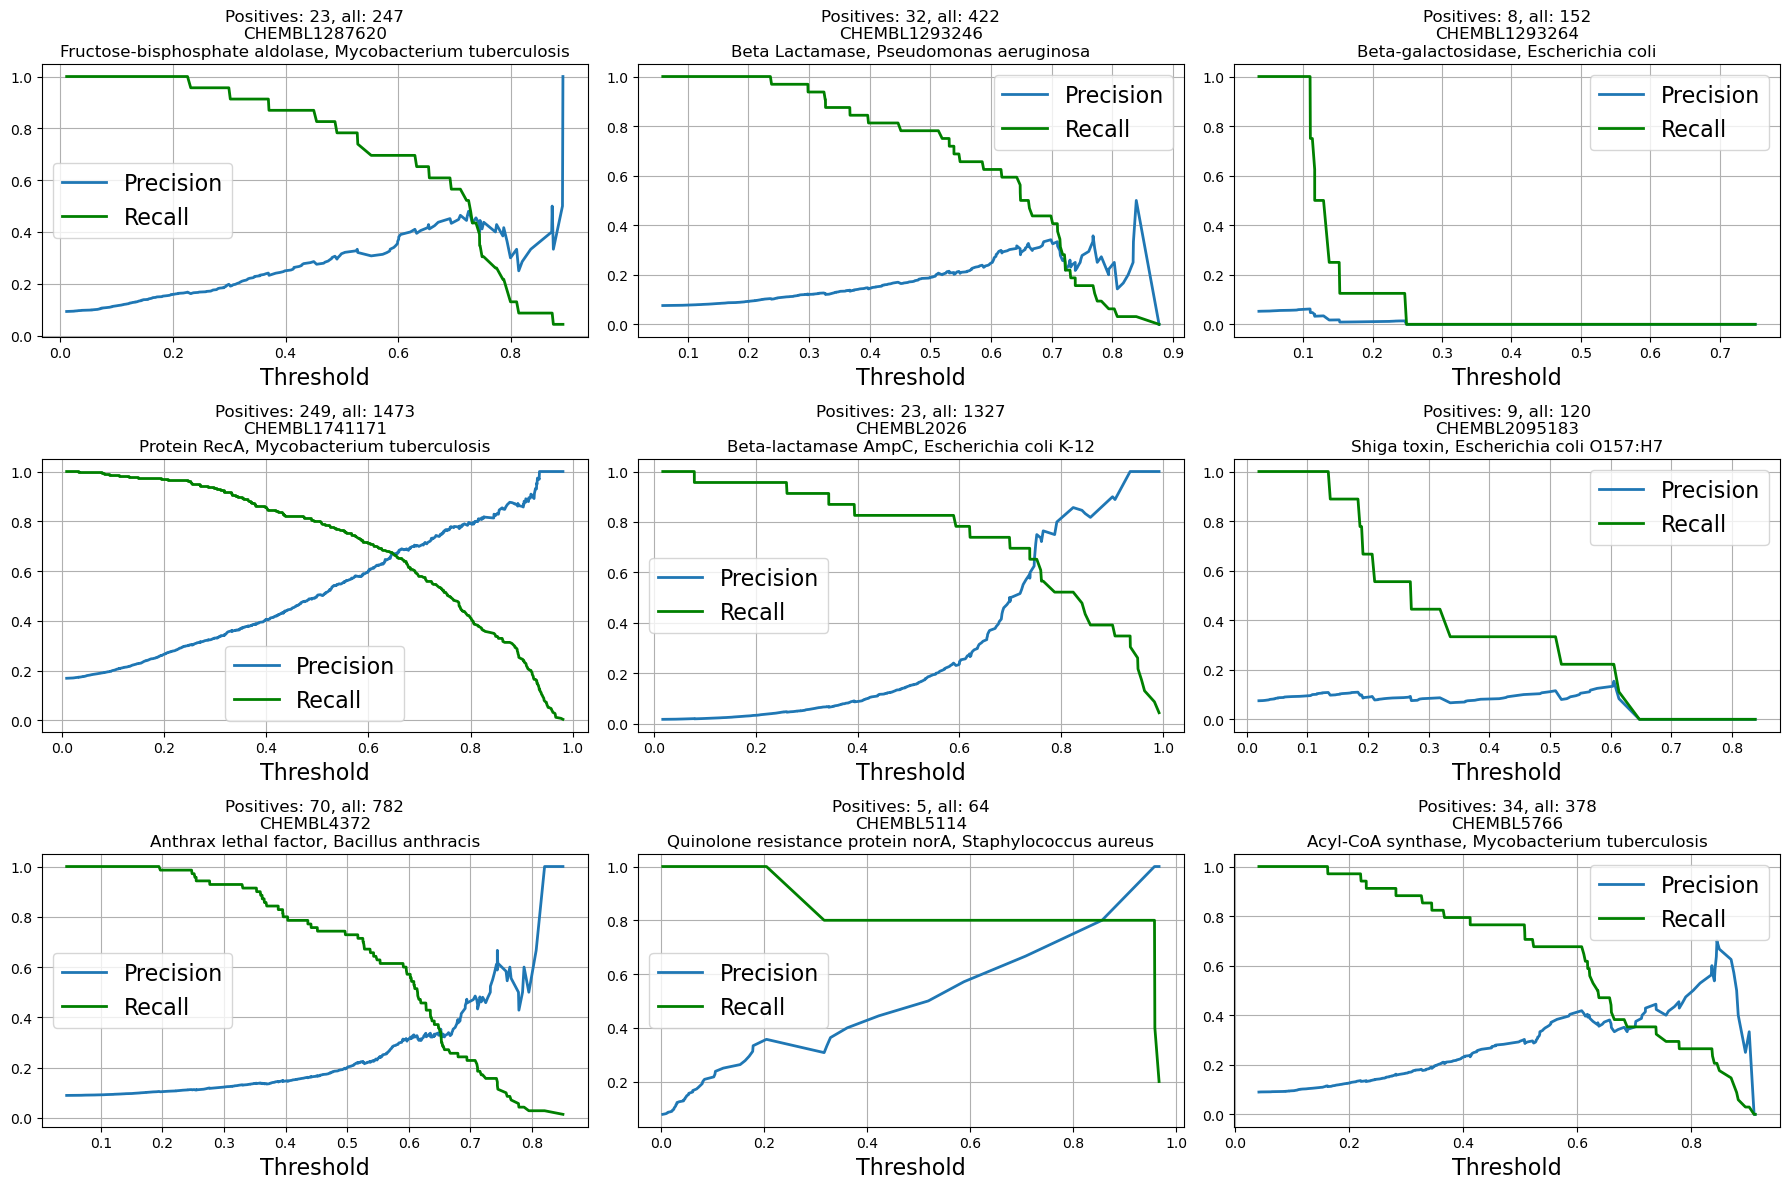

In [621]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18,12))
for head, ax in zip(range(9), axs.ravel(), ):
    #ax.set_xlim((-0.1,1.05))
    ax.set_title('Positives: '+ str(int(sum(test_labels[head]))) + ', all: ' + str(len(test_labels[head])) + '\n' + idx_to_target_name[head])  
    precision, recall, thresholds = precision_recall_curve(test_trues[head], test_pred_probas[head])
    plot_precision_recall_vs_threshold(precision, recall, thresholds, ax)
    plt.tight_layout()

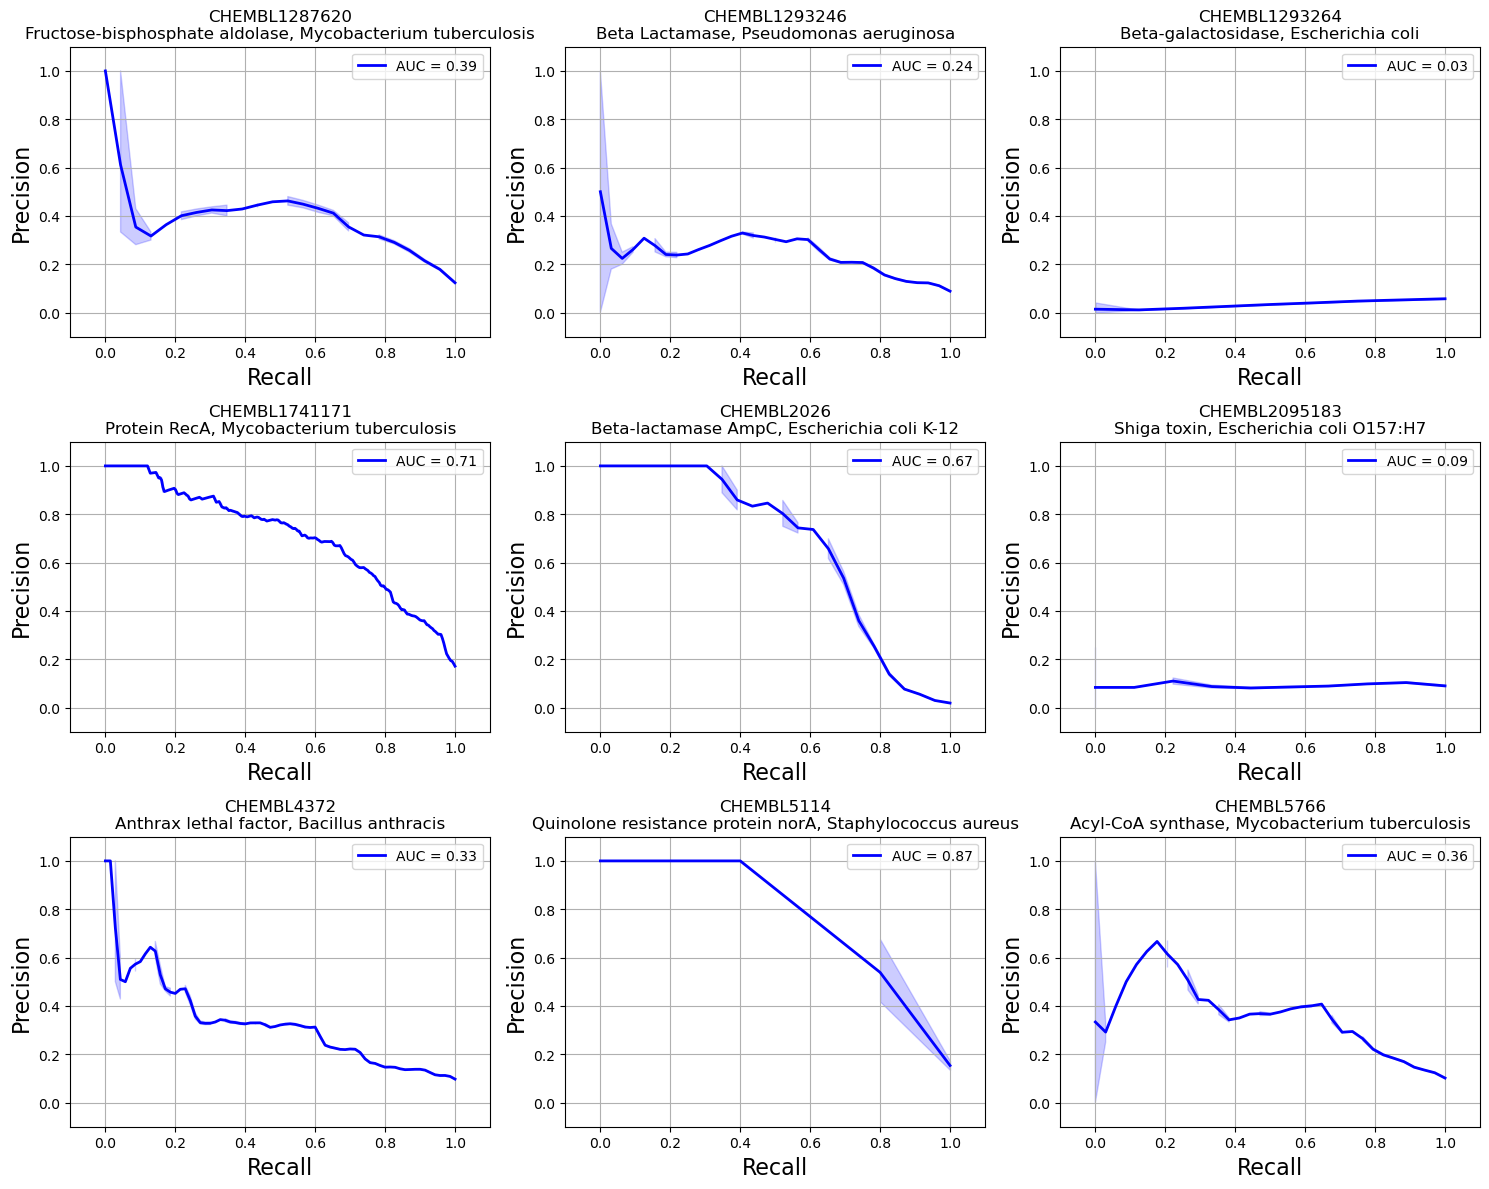

In [606]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for head,ax in zip(range(9), axs.ravel()): #f1,mcc, auprc, auroc, bedroc, random_bedroc,):
    test_precision_auc, test_recall_auc, test_threshold_auc = precision_recall_curve(test_trues[head], test_pred_probas[head][:], )   
    
    plot_precision_vs_recall(test_precision_auc, test_recall_auc, 'blue',f'AUC = {round(auc(test_recall_auc, test_precision_auc), 2)}', ax=ax, )
    ax.set_title(idx_to_target_name[head])
    plt.tight_layout()
#plt.savefig('pictures_2/mccs_auprcs_prior_classifier.png')

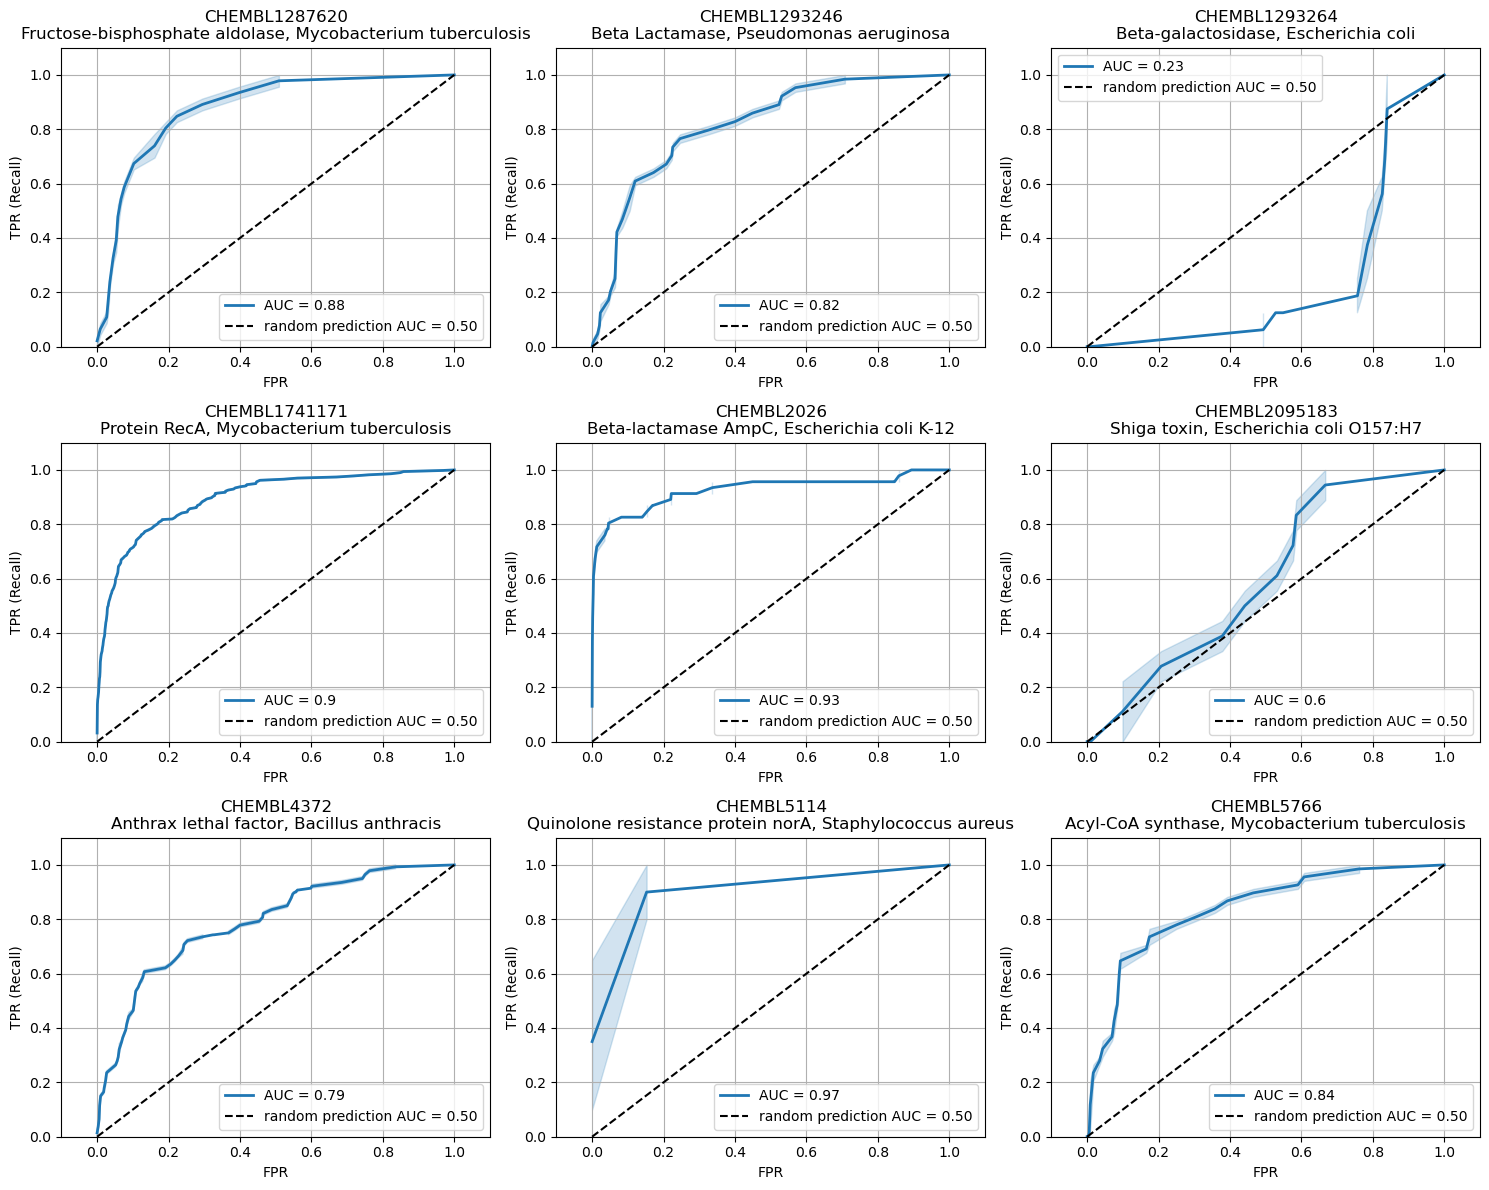

In [551]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for head,ax in zip(range(9), axs.ravel()): #f1,mcc, auprc, auroc, bedroc, random_bedroc,):
    test_fpr, test_tpr, test_thresholds = roc_curve(test_trues[head], test_pred_probas[head][:])
    plot_roc_curve(test_fpr, test_tpr, f'AUC = {round(auroc[head], 2)}', ax)
    ax.set_title(idx_to_target_name[head])
    ax.plot([0, 1], [0, 1], 'k--', label='random prediction AUC = 0.50')
    ax.legend()
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR (Recall)')
    plt.tight_layout()
#plt.savefig('pictures_2/maccs_aurocs.png')

### Since we can't estimate a probability distribution for the prior classifier, we can test for significant difference in performance using a permutation test

In [515]:
def permutation_test_between_clfs_prc(y_test, pred_proba_1, pred_proba_2, nsamples=1000):
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, pred_proba_1)
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, pred_proba_2)
    auc1 = auc(recall1, precision1)
    auc2 = auc(recall2, precision2)
    auc_differences = []
    observed_difference = auc1 - auc2
    for _ in range(nsamples):
        mask = np.random.randint(2, size=len(pred_proba_1))
        p1 = np.where(mask, pred_proba_1, pred_proba_2)
        p2 = np.where(mask, pred_proba_2, pred_proba_1)
        precision1, recall1, thresholds1 = precision_recall_curve(y_test, p1)
        precision2, recall2, thresholds2 = precision_recall_curve(y_test, p2)
        auc1 = auc(recall1, precision1)
        auc2 = auc(recall2, precision2)
        auc_differences.append(auc1 - auc2)
    return observed_difference, np.mean(auc_differences >= observed_difference)

In [485]:
def permutation_test_between_clfs_roc(y_test, pred_proba_1, pred_proba_2, nsamples=1000):
    auc_differences = []
    auc1 = roc_auc_score(y_test, pred_proba_1)
    auc2 = roc_auc_score(y_test, pred_proba_2)
    observed_difference = auc1 - auc2
    for _ in range(nsamples):
        mask = np.random.randint(2, size=len(pred_proba_1))
        p1 = np.where(mask, pred_proba_1, pred_proba_2)
        p2 = np.where(mask, pred_proba_2, pred_proba_1)
        auc1 = roc_auc_score(y_test, p1)
        auc2 = roc_auc_score(y_test, p2)
        auc_differences.append(auc1 - auc2)
    return observed_difference, np.mean(auc_differences >= observed_difference)

In [488]:
permu_results = []
for head in tqdm(range(9)):
    permu_results.append(permutation_test_between_clfs_roc(test_trues[head],test_pred_probas[head], prior_proba_predictions[head][:, 1]))

  0%|          | 0/9 [00:00<?, ?it/s]

In [667]:
permu_results

[(0.38198757763975166, 0.0),
 (0.3177884615384615, 0.003),
 (-0.2699652777777778, 0.972),
 (0.39547077197679603, 0.0),
 (0.42654707922112567, 0.003),
 (0.10160160160160159, 0.274),
 (0.2898073836276083, 0.0),
 (0.46949152542372885, 0.012),
 (0.3418262653898768, 0.0)]

In [519]:
permu_results_auprc = []
for head in tqdm(range(9)):
    y_test = test_trues[head].copy()
    permu_results_auprc.append(permutation_test_between_clfs_prc(test_trues[head],test_pred_probas[head], prior_proba_predictions[head][:, 1]))

  0%|          | 0/9 [00:00<?, ?it/s]

In [200]:
idx_to_bedroc = {} # target to BEDROC dict
for i, t in idx_to_target_name.items():
    idx_to_bedroc[i] = Scoring.CalcBEDROC(test_sorteds_li[46][i], 2, 20)

In [202]:
idx_to_bedroc

{0: 0.4688014922791565,
 1: 0.3441485868929647,
 2: 1.6839478909838665e-05,
 3: 0.8169547830315316,
 4: 0.7807682440166595,
 5: 0.06154741008295283,
 6: 0.44814256741463454,
 7: 0.9085568781464806,
 8: 0.49806407259500174}

### Estimate the BEDROC distribution for the random classifier by bootstrap and plot the observed BEDROC - if above the 95th percentile threshold, then the moedl performs statistically significantly better than the random.

In [215]:
random_bedrocs = {}
for t in range(9):
    random_bedrocs[t] = []
    for _ in range(10000):
        to_shuffle = test_sorteds_li[46][t].copy()
        np.random.shuffle(to_shuffle)
        random_bedrocs[t].append(Scoring.CalcBEDROC(to_shuffle, 2, 20))

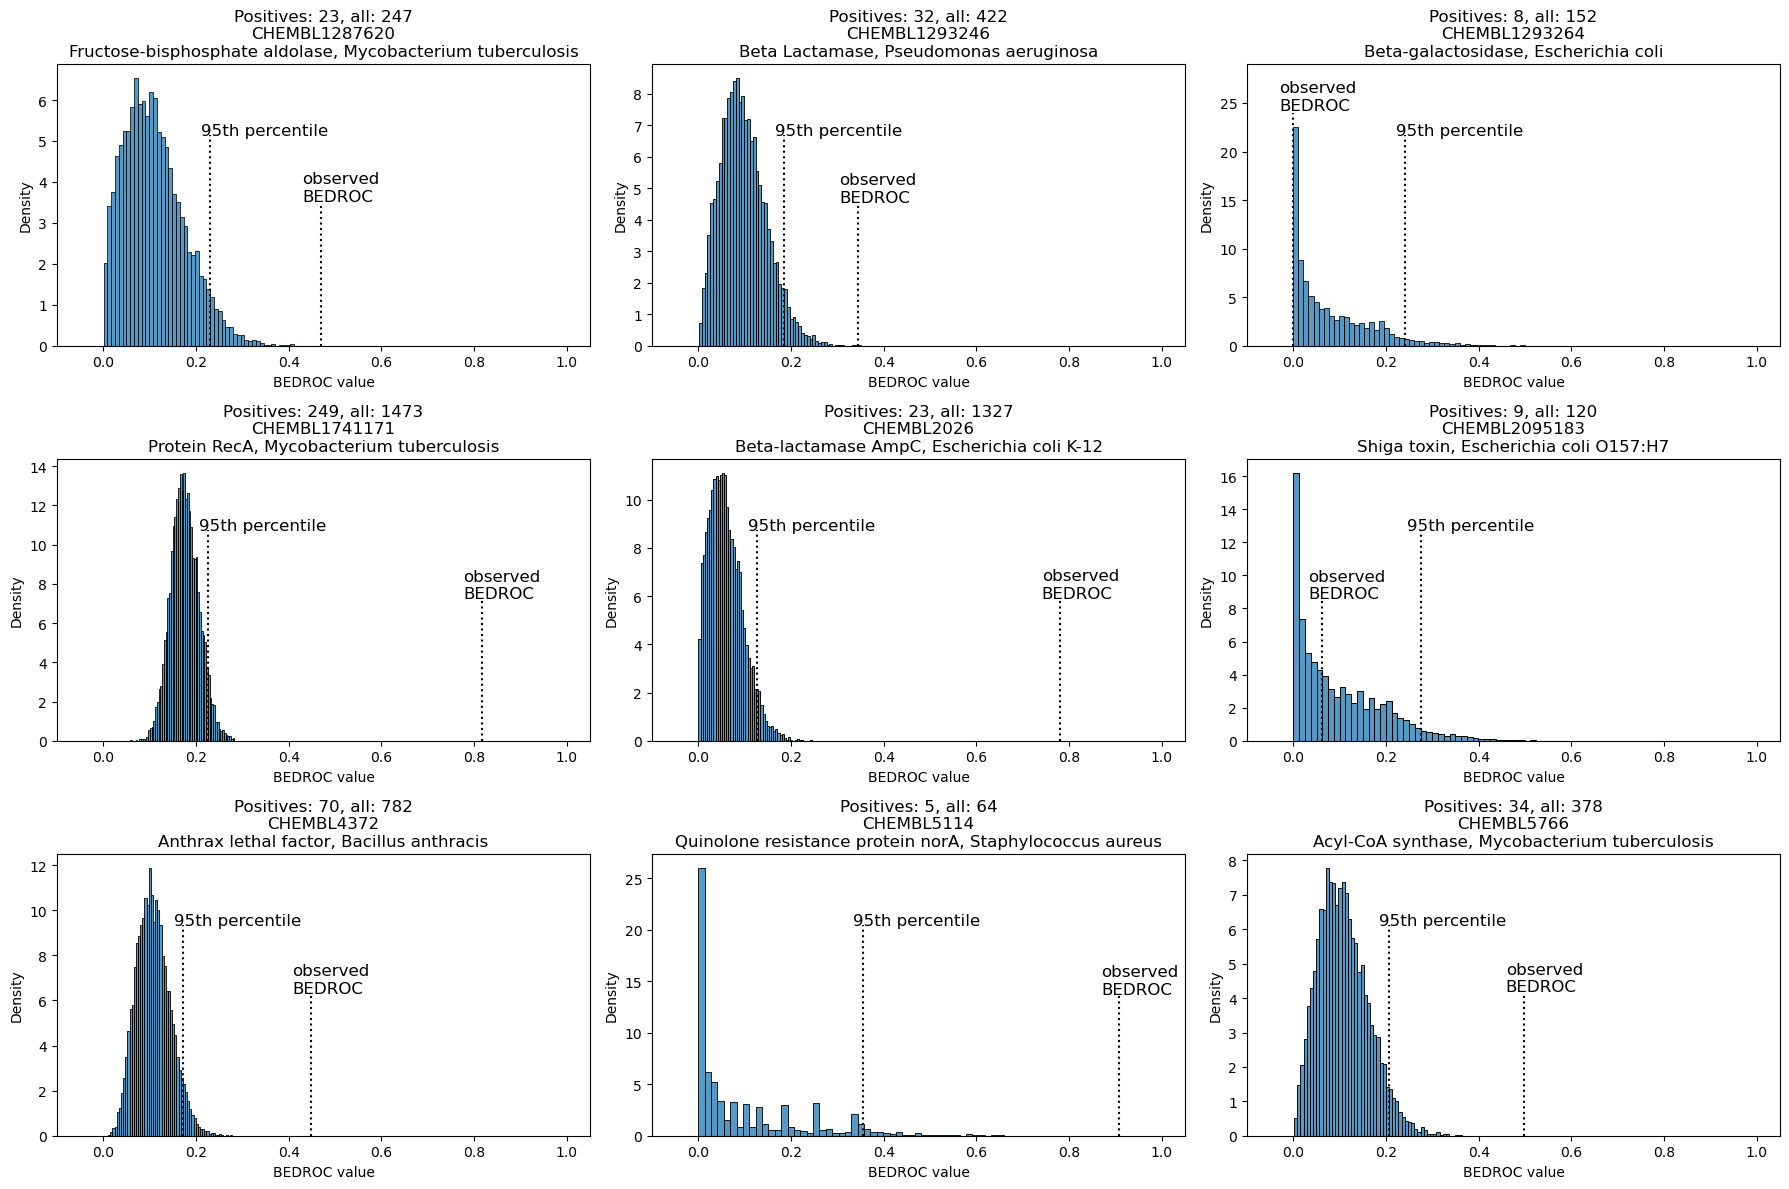

In [367]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18,12))
for i, ax in zip(range(9), axs.ravel(), ):
    sn.histplot(random_bedrocs[i], stat='density', ax=ax)
    ax.set_xlim((-0.1,1.05))
    ax.set_title('Positives: '+ str(int(sum(test_labels[i]))) + ', all: ' + str(len(test_labels[i])) + '\n' + idx_to_target_name[i])  
    ax.set_xlabel('BEDROC value')
    if i != 2 and i != 5:
        ax.vlines(np.quantile(random_bedrocs[i], 0.95), ymin=0, ymax=(3 * ax.get_ylim()[1]) / 4, color='black', linestyle = ":")
        ax.vlines(idx_to_bedroc[i],  ymin=0, ymax= ax.get_ylim()[1] / 2, color='black', linestyle = ":")
        ax.text(np.quantile(random_bedrocs[i], 0.95) - 0.02, y=(3 * ax.get_ylim()[1]) / 4, s='95th percentile', fontdict ={'fontsize':12})
        ax.text(idx_to_bedroc[i] - 0.04, y=(ax.get_ylim()[1] / 2) + 0.1, s='observed\nBEDROC', fontdict ={'fontsize':12})
        plt.tight_layout()
    elif i == 5:
        ax.vlines(np.quantile(random_bedrocs[i], 0.95), ymin=0, ymax=(3 * ax.get_ylim()[1]) / 4, color='black', linestyle = ":")
        ax.vlines(idx_to_bedroc[i],  ymin=0, ymax= ax.get_ylim()[1] / 2, color='black', linestyle = ":")
        ax.text(np.quantile(random_bedrocs[i], 0.95) - 0.03, y=(3 * ax.get_ylim()[1]) / 4, s='95th percentile', fontdict ={'fontsize':12})
        ax.text(idx_to_bedroc[i] - 0.03, y=(ax.get_ylim()[1] / 2) + 0.1, s='observed\nBEDROC', fontdict ={'fontsize':12})
        plt.tight_layout()
    else:    
        ax.set_ylim((0, 29))
        ax.vlines(np.quantile(random_bedrocs[i], 0.95), ymin=0, ymax=(3 * ax.get_ylim()[1]) / 4, color='black', linestyle = ":")
        ax.vlines(idx_to_bedroc[i],  ymin=0, ymax=24, color='black', linestyle = ":")
        ax.text(np.quantile(random_bedrocs[i], 0.95) - 0.02, y=(3 * ax.get_ylim()[1]) / 4, s='95th percentile', fontdict ={'fontsize':12})
        ax.text(idx_to_bedroc[i] - 0.03, y=24.3, s='observed\nBEDROC', fontdict ={'fontsize':12})
        plt.tight_layout()
    #ax.set_ylim((0., 11.5))
plt.savefig('pictures_2/bedroc_targets_random_maccs.png')

In [77]:
for i,t in idx_to_slr_threshold.items():
    print(np.array(t_bedrocs)[46,i])

0.4688014922791565
0.3441485868929647
1.6839478909838665e-05
0.8169547830315316
0.7807682440166595
0.06154741008295283
0.44814256741463454
0.9085568781464806
0.49806407259500174


In [80]:
test_sorteds_li[46][0] = sorted(test_sorteds_li[46][0], key=lambda x: x[0], reverse=True)

In [318]:
idx_to_tested_slr = {}
for i, t in idx_to_target_name.items():
    idx_to_tested_slr[i] = 0
    for rank, [score, _, active_bool] in enumerate(test_sorteds_li[46][i]):
        if active_bool:
            idx_to_tested_slr[i] += np.log(rank + 1)

In [71]:
idx_to_slr_threshold = {}
for i,t in idx_to_target_name.items():
    print(i, sum(test_labels[i]), len(test_labels[i]))
    idx_to_slr_threshold[i] = sum(test_labels[i]) * np.log(len(test_labels[i])) - gamma(sum(test_labels[i])).ppf(0.95)

0 23.0 247
1 32.0 422
2 8.0 152
3 249.0 1473
4 23.0 1327
5 9.0 120
6 70.0 782
7 5.0 64
8 34.0 378


In [72]:
idx_to_slr_threshold

{0: 95.3011215367394,
 1: 151.6025396777919,
 2: 27.042930364338098,
 3: 1540.957735558493,
 4: 133.97073858393668,
 5: 28.6527759698421,
 6: 382.02335471136183,
 7: 11.640896390160785,
 8: 157.66132044012895}

In [87]:
idx_to_tested_slr

{0: 73.71625947237688,
 1: 127.34299863836391,
 2: 37.87036658707031,
 3: 1229.735519052436,
 4: 69.03859063364666,
 5: 33.271945184206324,
 6: 317.74362996200915,
 7: 5.817111159963204,
 8: 125.14950690432582}

In [88]:
slr_differences = []
for i,t in idx_to_target_name.items():
    slr_differences.append((idx_to_tested_slr[i] - idx_to_slr_threshold[i]) / idx_to_slr_threshold[i])

In [158]:
def change_alpha(handle, original):
    ''' Change the alpha and marker style of the legend handles '''
    handle.update_from(original)
    handle.set_alpha(1)
    handle.set_marker('.')


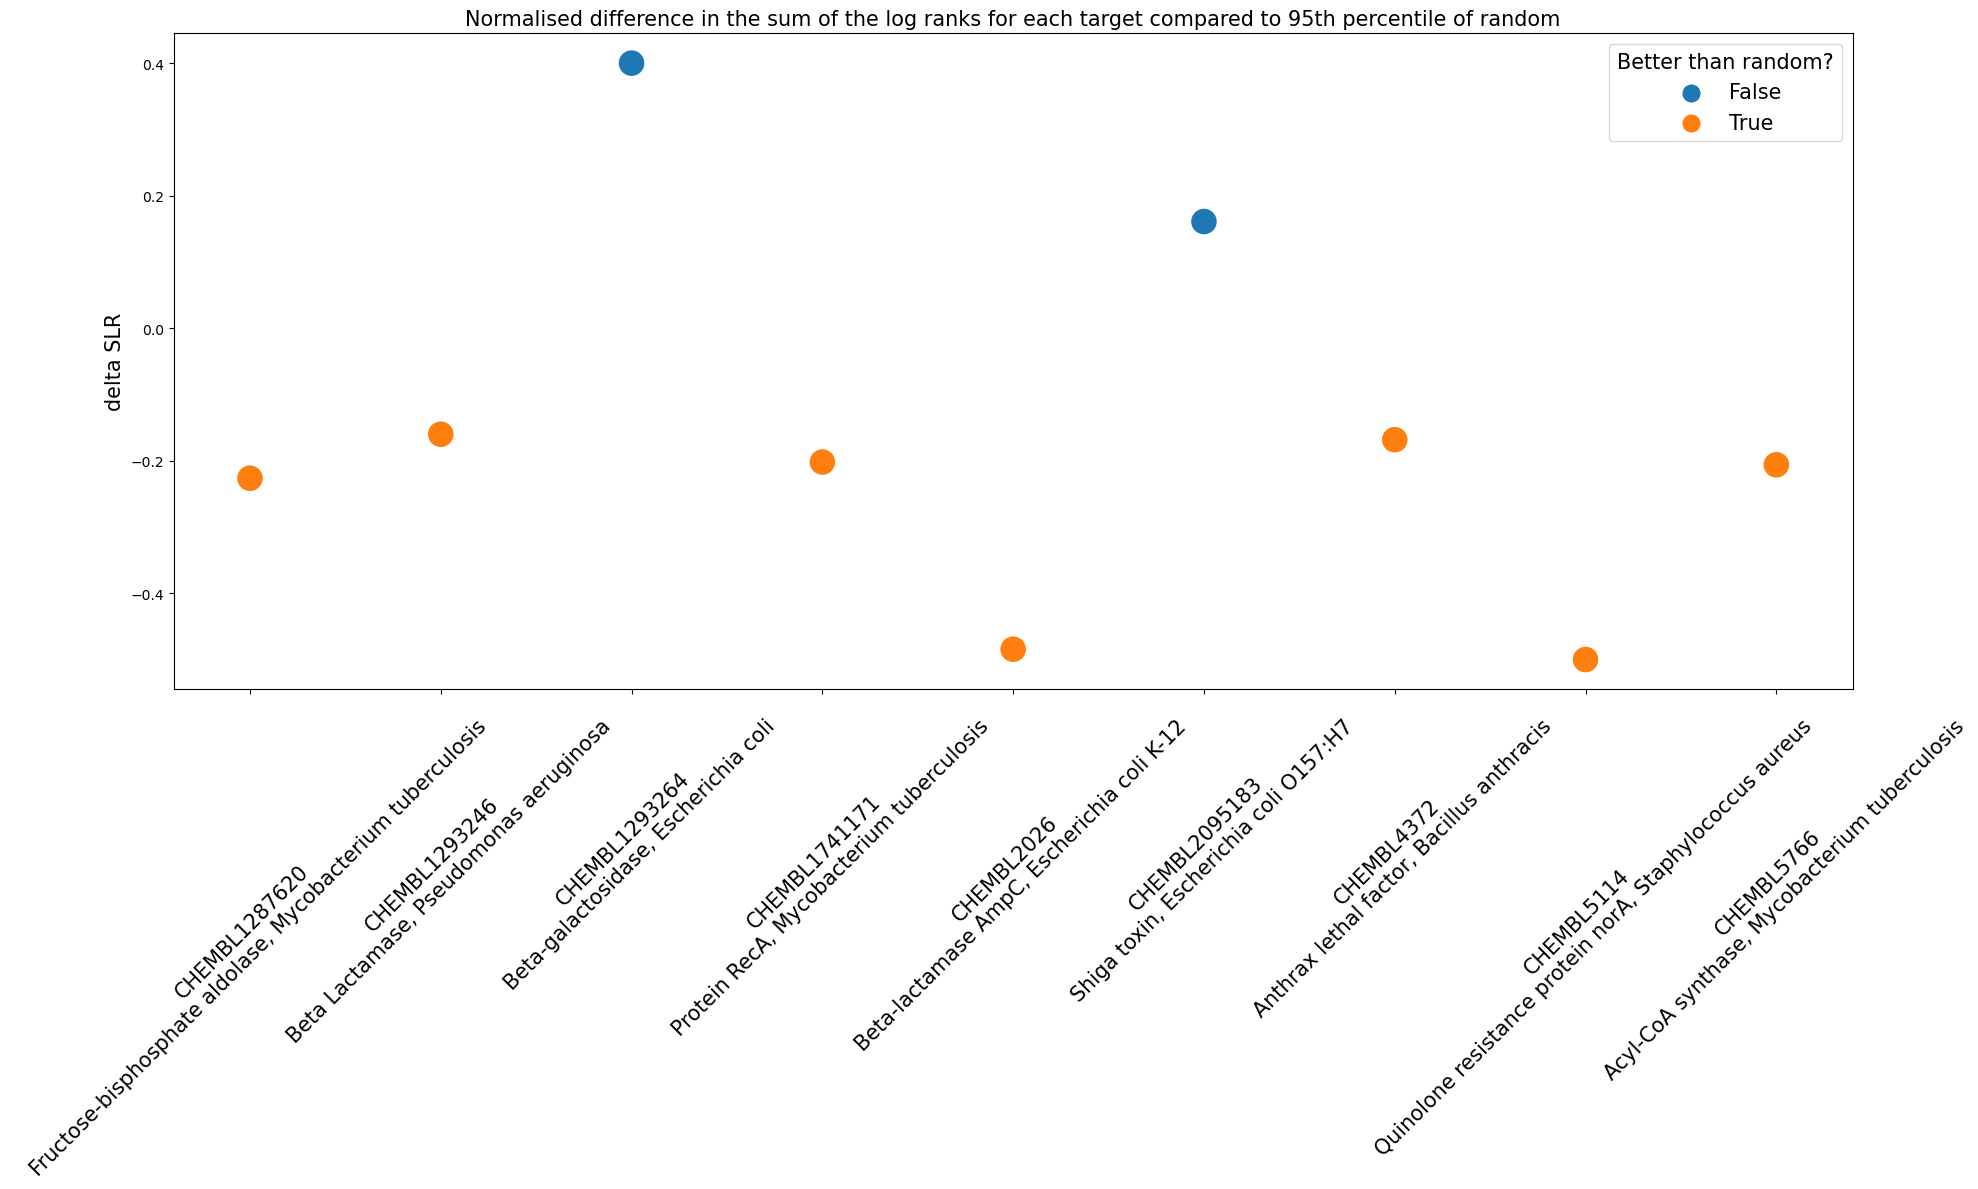

In [499]:
plt.figure(figsize=(20,12))
g=sn.scatterplot(y=slr_differences,x=idx_to_target_name.values(), hue=np.array(slr_differences)<0, s=400, )

g.legend(prop={'size': 15}, markerscale=2,)
g.legend_.set_title('Better than random?', prop={'size': 15})
plt.title('Normalised difference in the sum of the log ranks for each target compared to 95th percentile of random', fontsize=15)
plt.ylabel('delta SLR', fontsize=15)
plt.xticks(rotation=45, fontsize=15)
plt.tight_layout()
plt.savefig('pictures_2/slr_maccs.png')

In [590]:
model_ecfp4.load_state_dict(torch.load("only_unique_examples_data/model_fp2_2048_0002.pcl"))

<All keys matched successfully>

In [676]:
# we would like the sequence of inputs to be the same in both cases, hence the shuffle=False flag
test_loader = D.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=g) 
test_loader_ecfp4 = D.DataLoader(test_dataset_ecfp4, batch_size=BATCH_SIZE, shuffle=False, generator=g) 

In [677]:
test_loss, test_loss_by_target, test_sorteds, f1,mcc, auprc, auroc, bedroc, random_bedroc, test_predictions, test_pred_probas, test_trues  = test(model, test_loader, criterion)

In [678]:
test_loss_ecfp4, test_loss_by_target_ecfp4, test_sorteds_ecfp4, f1_ecfp4, mcc_ecfp4, auprc_ecfp4, auroc_ecfp4, bedroc_ecfp4, random_bedroc_ecfp4, test_predictions_ecfp4, test_pred_probas_ecfp4, test_trues_ecfp4  = test(model2, test_loader_ecfp4, criterion)

## Test for significance in the difference between the two models

### AUROC

In [680]:
auc_permu_res = []
for head in range(9):
    auc_permu_res.append(permutation_test_between_clfs_roc(test_trues[head], test_pred_probas_ecfp4[head], test_pred_probas[head]))

In [681]:
auc_permu_res

[(0.025232919254658315, 0.272),
 (0.11498397435897434, 0.0),
 (0.03732638888888887, 0.267),
 (0.032686300758590026, 0.0),
 (-0.01917177914110424, 0.693),
 (0.09509509509509506, 0.153),
 (0.07020465489566619, 0.002),
 (0.01016949152542379, 0.514),
 (0.0790013679890561, 0.006)]

### AUPRC

In [682]:
auprc_permu_res = []
for head in tqdm(range(9)):
    auprc_permu_res.append(permutation_test_between_clfs_prc(test_trues[head], test_pred_probas_ecfp4[head], test_pred_probas[head]))

  0%|          | 0/9 [00:00<?, ?it/s]

In [683]:
auprc_permu_res

[(0.21170506481623708, 0.051),
 (0.26447164419049496, 0.001),
 (0.010147742744403755, 0.0),
 (0.07353441727053756, 0.001),
 (-0.148194041848559, 0.909),
 (0.0468470128499586, 0.093),
 (0.16040723565258774, 0.004),
 (0.01897102897102898, 0.456),
 (0.29947799501954975, 0.0)]

## Now the meaningful metrics for early recognition

In [ ]:
def delta_bedroc(arr1, arr2):
    global ecfp2_sorted_0
    # arr1, arr2 are permuted
    new_arr1 = np.array([1 if i in arr1 else 0 for i in range(len(ecfp2_sorted_0))]).reshape(-1,1)
    new_arr2 = np.array([1 if i in arr2 else 0 for i in range(len(ecfp2_sorted_0))]).reshape(-1,1)
    return Scoring.CalcBEDROC(new_arr1, 0, 20) - Scoring.CalcBEDROC(new_arr2, 0, 20)

In [351]:
stats_outs2 = []
p_vals2 = []
for head in tqdm(range(9)):
    ecfp2_sorted_0 = test_sorted_ecfp2[head].copy()
    maccs_sorted_0 = test_sorteds_li[46][head].copy()
    
    ranks1 = [i for i, x,  in enumerate(ecfp2_sorted_0) if x[2] == 1]
    ranks2 = [i for i, x in enumerate(maccs_sorted_0) if x[2] == 1]

    copied_ranks1, copied_ranks2 = ranks1.copy(), ranks2.copy()
    
    res = permutation_test([copied_ranks1, copied_ranks2],statistic=delta_bedroc, n_resamples=2000)
    p_vals2.append(res.pvalue)
    stats_outs2.append(res.statistic)
    print(idx_to_target_name[head], p_vals2[-1], stats_outs2[-1])

  0%|          | 0/9 [00:00<?, ?it/s]

CHEMBL1287620
Fructose-bisphosphate aldolase, Mycobacterium tuberculosis 0.12293853073463268 0.22398440798546854
CHEMBL1293246
Beta Lactamase, Pseudomonas aeruginosa 0.0079960019990005 0.3110319743296247
CHEMBL1293264
Beta-galactosidase, Escherichia coli 0.5427286356821589 0.11187142952557957
CHEMBL1741171
Protein RecA, Mycobacterium tuberculosis 0.20689655172413793 0.06285668437609704
CHEMBL2026
Beta-lactamase AmpC, Escherichia coli K-12 0.25287356321839083 -0.13579388166918382
CHEMBL2095183
Shiga toxin, Escherichia coli O157:H7 0.463768115942029 0.11988948255021212
CHEMBL4372
Anthrax lethal factor, Bacillus anthracis 0.09795102448775612 0.1487641851877214
CHEMBL5114
Quinolone resistance protein norA, Staphylococcus aureus 1.0 0.009076773206284194
CHEMBL5766
Acyl-CoA synthase, Mycobacterium tuberculosis 0.03498250874562719 0.2558057890576374


In [352]:
def delta_slr(arr1, arr2):
    global ecfp2_sorted_0
    slr1, slr2 = 0, 0
    for rank1, rank2 in zip(arr1, arr2):
        slr1 += np.log(rank1 + 1)
        slr2 += np.log(rank2 + 1)
        
    return slr1 - slr2

In [354]:
stats_outs_slr = []
p_vals_slr = []
for head in tqdm(range(9)):
    ecfp2_sorted_0 = test_sorted_ecfp2[head].copy()
    maccs_sorted_0 = test_sorteds_li[46][head].copy()
    
    ranks1 = [i for i, x,  in enumerate(ecfp2_sorted_0) if x[2] == 1]
    ranks2 = [i for i, x in enumerate(maccs_sorted_0) if x[2] == 1]

    copied_ranks1, copied_ranks2 = ranks1.copy(), ranks2.copy()
    
    res = permutation_test([copied_ranks1, copied_ranks2],statistic=delta_slr, n_resamples=2000)
    p_vals_slr.append(res.pvalue)
    stats_outs_slr.append(res.statistic)
    print(idx_to_target_name[head], p_vals_slr[-1], stats_outs_slr[-1])

  0%|          | 0/9 [00:00<?, ?it/s]

CHEMBL1287620
Fructose-bisphosphate aldolase, Mycobacterium tuberculosis 0.28585707146426786 -8.277342607218216
CHEMBL1293246
Beta Lactamase, Pseudomonas aeruginosa 0.012993503248375811 -22.931386430703213
CHEMBL1293264
Beta-galactosidase, Escherichia coli 0.8075962018990505 -2.5266960140872285
CHEMBL1741171
Protein RecA, Mycobacterium tuberculosis 0.27386306846576713 -29.058832454216372
CHEMBL2026
Beta-lactamase AmpC, Escherichia coli K-12 0.447776111944028 9.437002751726453
CHEMBL2095183
Shiga toxin, Escherichia coli O157:H7 0.3288355822088955 -3.769172032633236
CHEMBL4372
Anthrax lethal factor, Bacillus anthracis 0.14392803598200898 -26.228672012742607
CHEMBL5114
Quinolone resistance protein norA, Staphylococcus aureus 0.9841269841269841 -0.24116205681688818
CHEMBL5766
Acyl-CoA synthase, Mycobacterium tuberculosis 0.06096951524237881 -18.78490822507048


# Applicability domain -> analyse the similarity between the most similar molecules in the train and test sets and whether that correlates with 

In [694]:
simis_test_to_train = {} # stores the max similarity of a test set molecule to any train set molecule
dfs_dict = {} # dictionary to store the datafranes for each target

for head in tqdm(range(9)):
    max_simis = []
    df = pd.DataFrame(columns=['mol_index','max_similarity','Test Label', 'Train Label of Most Similar'])
    train_mol_label = []

    for i, test_fp in enumerate(test_dataset.bv_fps[head]):
        _simis = []
        for j, train_fp in enumerate(train_dataset.bv_fps[head]):
            curr_simi = DataStructs.TanimotoSimilarity(test_fp, train_fp)
            _simis.append(curr_simi)
        max_simis.append(max(_simis))
        train_mol_label.append(train_dataset.labels[head][np.argmax(_simis)])
    
    df['mol_index'] = range(len(max_simis))
    df['max_similarity'] = max_simis
    df['Test Label'] = test_dataset.labels[head]
    df['Train Label of Most Similar'] = train_mol_label
    dfs_dict[head] = df
    simis_test_to_train[head] = max_simis

  0%|          | 0/9 [00:00<?, ?it/s]

In [695]:
def concat_test_train_label(row):
    return str(int(row['Test Label'])) + '_' +str(int(row['Train Label of Most Similar']))

In [696]:
for head in tqdm(range(9)):
    dfs_dict[head]['Test_Train Label'] = dfs_dict[head].apply(concat_test_train_label, axis=1)

  0%|          | 0/9 [00:00<?, ?it/s]

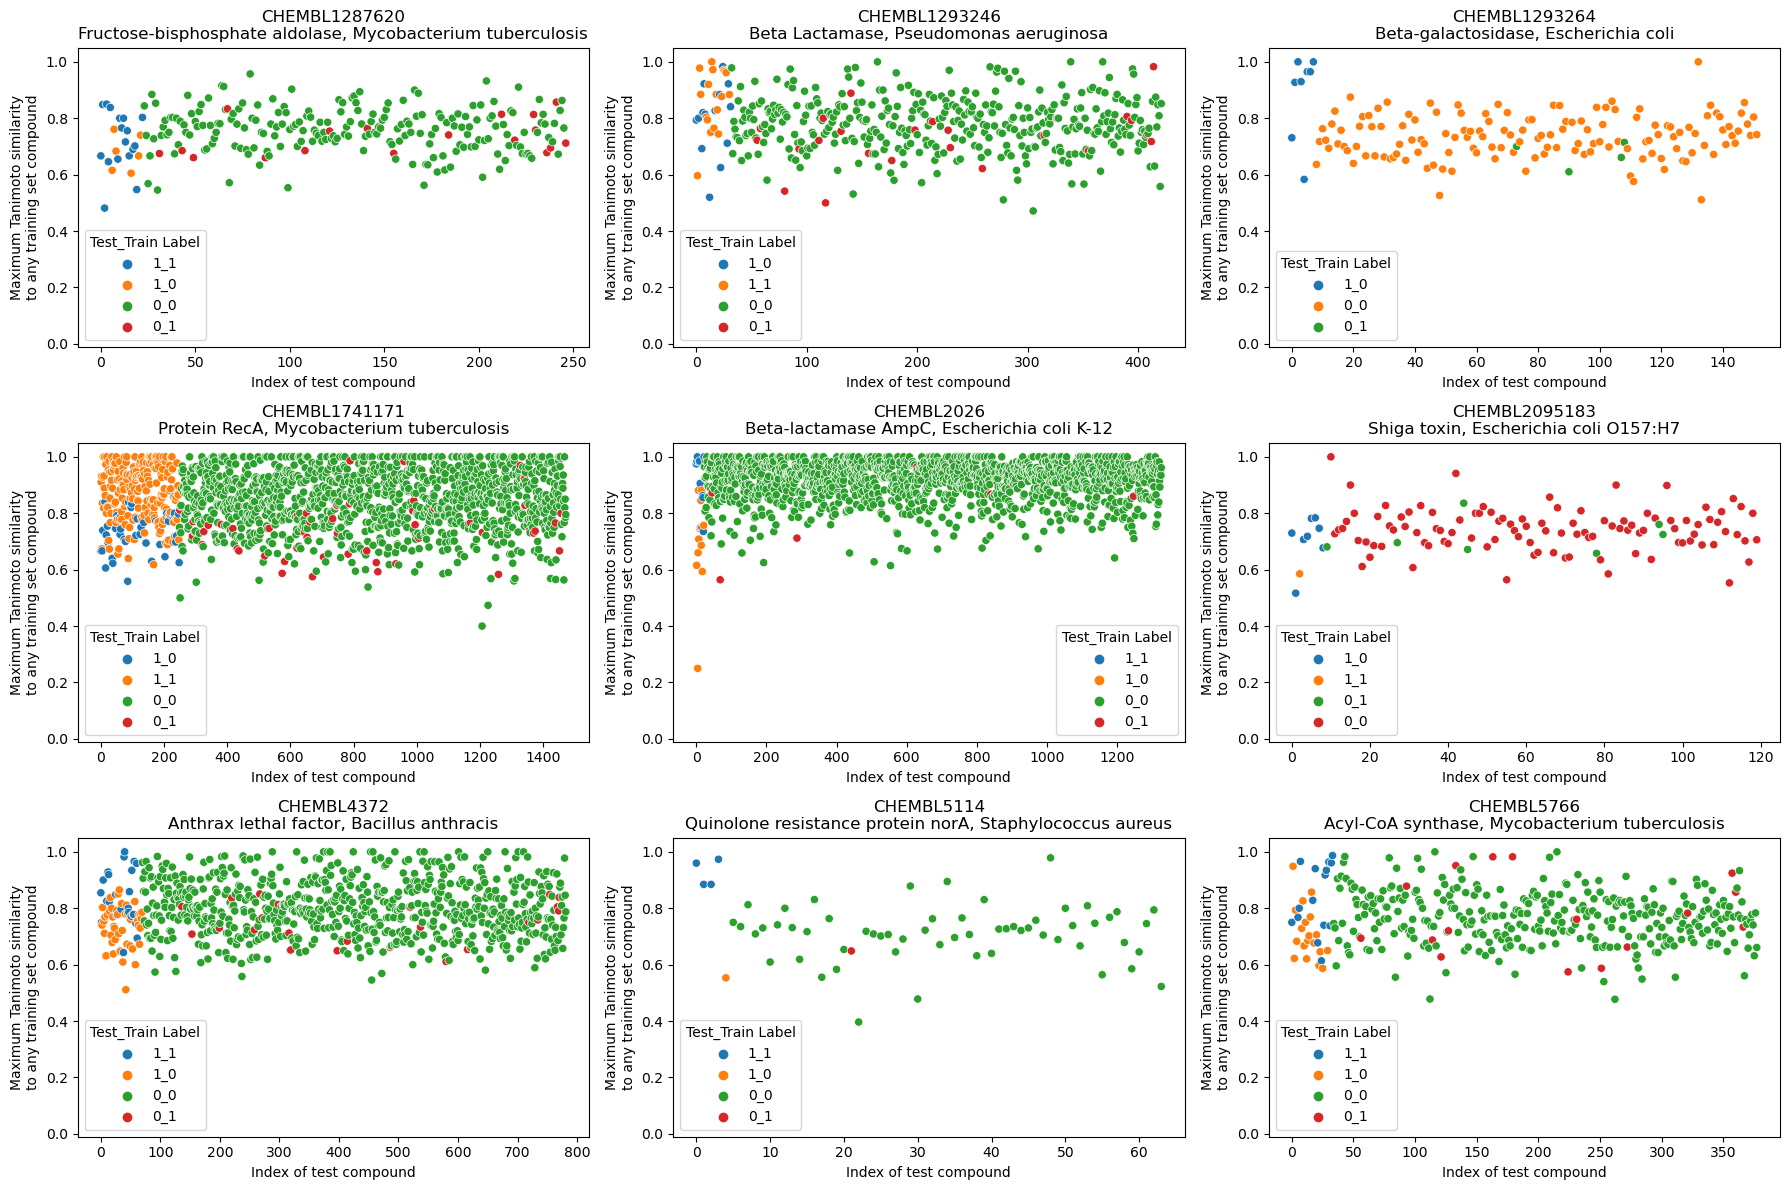

In [697]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
for head, ax in zip(range(9), axs.ravel(),):
    sn.scatterplot(data=dfs_dict[head], x='mol_index', y='max_similarity', hue='Test_Train Label', ax=ax)
    ax.set_ylim((-0.01,1.05))
    ax.set_xlabel('Index of test compound')
    ax.set_ylabel('Maximum Tanimoto similarity\nto any training set compound')
    ax.set_title(idx_to_target_name[head])
    plt.tight_layout()
plt.savefig('pictures_2/applicability_domain_by_labels_MACCS.png')